In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [36]:
df = pd.read_excel('/content/indicadores_CT.xlsx', sheet_name=None)

df_ingressantes = df['ingressantes']
df_concluidos = df['concluidos']
df_cancelados = df['cancelados']

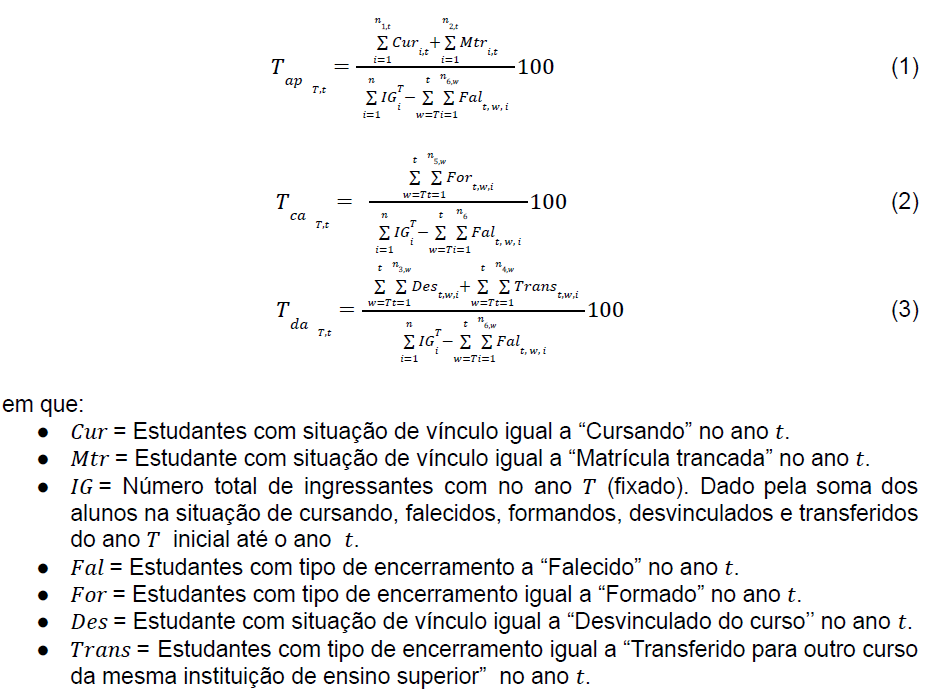

In [37]:
# LIMPEZA E PADRONIZAÇÃO

# INGRESSANTES
df_ingressantes = df_ingressantes.dropna(subset=['ano_referencia']).copy()
df_ingressantes['ano_ingresso'] = df_ingressantes['ano_referencia'].astype(int)
df_ingressantes['id_discente'] = df_ingressantes['id_discente'].astype(str)
df_ingressantes['qtd_TRANCADO'] = pd.to_numeric(df_ingressantes['qtd_TRANCADO'], errors='coerce').fillna(0)

# CONCLUIDOS
df_concluidos = df_concluidos.dropna(subset=['ano_conclusao']).copy()
df_concluidos['ano_conclusao'] = df_concluidos['ano_conclusao'].astype(int)
if 'ano_referencia' in df_concluidos.columns:
    df_concluidos['ano_ingresso'] = df_concluidos['ano_referencia'].astype(int)
else:
    df_concluidos['ano_ingresso'] = df_concluidos['ano_conclusao']
df_concluidos['id_discente'] = df_concluidos['id_discente'].astype(str)

# CANCELADOS
df_cancelados = df_cancelados.dropna(subset=['ano_referencia']).copy()
df_cancelados['ano_ingresso'] = df_cancelados['ano_referencia'].astype(int)
df_cancelados['ano_referencia'] = df_cancelados['ano_referencia'].astype(int)
df_cancelados['id_discente'] = df_cancelados['id_discente'].astype(str)

# Verificar se deu tudo certo
print("Ingressantes:")
print(df_ingressantes[['ano_ingresso', 'id_discente', 'qtd_TRANCADO']].head())

print("\nConcluidos:")
print(df_concluidos[['ano_ingresso', 'ano_conclusao', 'id_discente']].head())

print("\nCancelados:")
print(df_cancelados[['ano_ingresso', 'ano_referencia', 'tipo_ocorrencia', 'id_discente']].head())

Ingressantes:
   ano_ingresso id_discente  qtd_TRANCADO
0          2013       45776             0
1          2016       45923             0
2          2015       45924             6
3          2011       45941             0
4          2016       45948             0

Concluidos:
   ano_ingresso  ano_conclusao id_discente
0          2011           2011       44709
1          2024           2024       44743
2          2011           2011       45479
3          2011           2011       45483
4          2011           2011       45489

Cancelados:
   ano_ingresso  ano_referencia            tipo_ocorrencia id_discente
0          2018            2018  CANCELAMENTO POR ABANDONO       44640
1          2016            2016  CANCELAMENTO POR ABANDONO       44661
2          2019            2019  CANCELAMENTO POR ABANDONO       44661
3          2018            2018  CANCELAMENTO POR ABANDONO       44744
4          2018            2018  CANCELAMENTO POR ABANDONO       44745


TAP - Taxa de permanência

In [39]:
# Definir anos de ingresso (coorte)
anos_t = sorted(df_ingressantes['ano_ingresso'].unique())

# Lista para resultados TAP simplificada
tap_resultados_simplificada = []

# Loop por coorte T
for T in anos_t:
    # IG_T
    ig_alunos = df_ingressantes[df_ingressantes['ano_ingresso'] == T]['id_discente'].unique()
    IG_T = len(ig_alunos)

    # Quem está em cancelados?
    cancelados_ids = df_cancelados[df_cancelados['ano_ingresso'] == T]['id_discente'].unique()

    # Quem está em concluidos?
    concluidos_ids = df_concluidos[df_concluidos['ano_ingresso'] == T]['id_discente'].unique()

    # Alunos ativos = ingressantes da coorte T que NÃO estão em cancelados nem concluidos
    ativos = df_ingressantes[
        (df_ingressantes['ano_ingresso'] == T) &
        (~df_ingressantes['id_discente'].isin(cancelados_ids)) &
        (~df_ingressantes['id_discente'].isin(concluidos_ids))
    ]['id_discente'].nunique()

    # TAP simplificada
    tap = (ativos / IG_T) * 100 if IG_T > 0 else 0

    # Guardar resultado
    tap_resultados_simplificada.append({
        'Ano_ingresso': T,
        'TAP_simplificada': tap
    })

# Converter resultados TAP para dataframe
df_tap_simplificada = pd.DataFrame(tap_resultados_simplificada)

# Exibir primeiros resultados
print("\nTaxa de Permanência (TAP)")
print(df_tap_simplificada)


Taxa de Permanência (TAP)
    Ano_ingresso  TAP_simplificada
0           2010         33.333333
1           2011          0.000000
2           2012          0.000000
3           2013          0.000000
4           2014          0.000000
5           2015          0.000000
6           2016          0.000000
7           2017          0.000000
8           2018          0.000000
9           2019          0.000000
10          2020          0.205550
11          2021          0.285307
12          2022          0.106838
13          2023          0.000000
14          2024          5.471125


De 2011 a 2019 → TAP = 0%

Isso significa que para as coortes 2011 a 2019, todos os alunos foram marcados como cancelados ou concluidos.
Não sobra nenhum "ativo" nas tabelas.

Isso é normal para coortes antigas → já se passaram anos suficientes para que todos os alunos tenham tido um desfecho (formado ou cancelado).





Para 2024 → TAP ≈ 5%
Isso significa que na coorte 2024:

Alguns alunos ainda não foram cancelados nem concluidos.

Provavelmente são alunos recentes que ainda estão "cursando" → ou não tiveram seus registros atualizados ainda.

Isso também é esperado, pois coortes recentes ainda têm alunos ativos.

TCA - Taxa de conclusão

In [43]:
# Definir anos de ingresso (coorte)
anos_t = sorted(df_ingressantes['ano_ingresso'].unique())

# Lista para resultados TCA simplificada
tca_resultados_simplificada = []

# Loop por coorte T
for T in anos_t:
    # IG_T — total de ingressantes da coorte T
    ig_alunos = df_ingressantes[df_ingressantes['ano_ingresso'] == T]['id_discente'].unique()
    IG_T = len(ig_alunos)

    # Concluidos que realmente são da coorte T (interseção)
    concluidos_ids = df_concluidos[df_concluidos['id_discente'].isin(ig_alunos)]['id_discente'].unique()
    concluidos_count = len(concluidos_ids)

    # TCA simplificada
    tca = (concluidos_count / IG_T) * 100 if IG_T > 0 else 0

    # Guardar resultado
    tca_resultados_simplificada.append({
        'Ano_ingresso': T,
        'TCA_simplificada': tca
    })

# Converter resultados TCA para dataframe
df_tca_simplificada = pd.DataFrame(tca_resultados_simplificada)

# Exibir primeiros resultados
print("\nTaxa de Conclusão (TCA)")
print(df_tca_simplificada)


Taxa de Conclusão (TCA)
    Ano_ingresso  TCA_simplificada
0           2010          0.000000
1           2011          1.176471
2           2012          1.255230
3           2013          4.878049
4           2014         24.390244
5           2015         31.087470
6           2016         48.209366
7           2017         51.703878
8           2018         52.238806
9           2019         51.666667
10          2020         42.651593
11          2021         53.209700
12          2022         43.162393
13          2023         44.073749
14          2024          2.431611


TDA - Taxa de desistência

In [44]:
# Definir anos de ingresso (coorte)
anos_t = sorted(df_ingressantes['ano_ingresso'].unique())

# Lista para resultados TDA simplificada
tda_resultados_simplificada = []

# Loop por coorte T
for T in anos_t:
    # IG_T — total de ingressantes da coorte T
    ig_alunos = df_ingressantes[df_ingressantes['ano_ingresso'] == T]['id_discente'].unique()
    IG_T = len(ig_alunos)

    # Cancelados com tipo_ocorrencia desejada — apenas se o aluno é da coorte T (conferido pelo id_discente)
    cancelados_ids = df_cancelados[
        (df_cancelados['id_discente'].isin(ig_alunos)) &
        (df_cancelados['tipo_ocorrencia'].str.contains('DESISTÊNCIA|CANCELAMENTO|TRANSF.P/OUTRA', case=False, na=False))
    ]['id_discente'].unique()

    cancelados_count = len(cancelados_ids)

    # TDA simplificada
    tda = (cancelados_count / IG_T) * 100 if IG_T > 0 else 0

    # Guardar resultado
    tda_resultados_simplificada.append({
        'Ano_ingresso': T,
        'TDA_simplificada': tda
    })

# Converter resultados TDA para dataframe
df_tda_simplificada = pd.DataFrame(tda_resultados_simplificada)

# Exibir primeiros resultados
print("\nTaxa de Desistência (TDA) — resultados por coorte:")
print(df_tda_simplificada)


Taxa de Desistência (TDA) — resultados por coorte:
    Ano_ingresso  TDA_simplificada
0           2010         33.333333
1           2011         43.529412
2           2012         96.234310
3           2013         89.329268
4           2014         72.439024
5           2015         37.352246
6           2016         45.730028
7           2017         46.180964
8           2018         46.153846
9           2019         47.941176
10          2020         51.181912
11          2021         44.222539
12          2022         54.807692
13          2023         56.716418
14          2024         79.939210


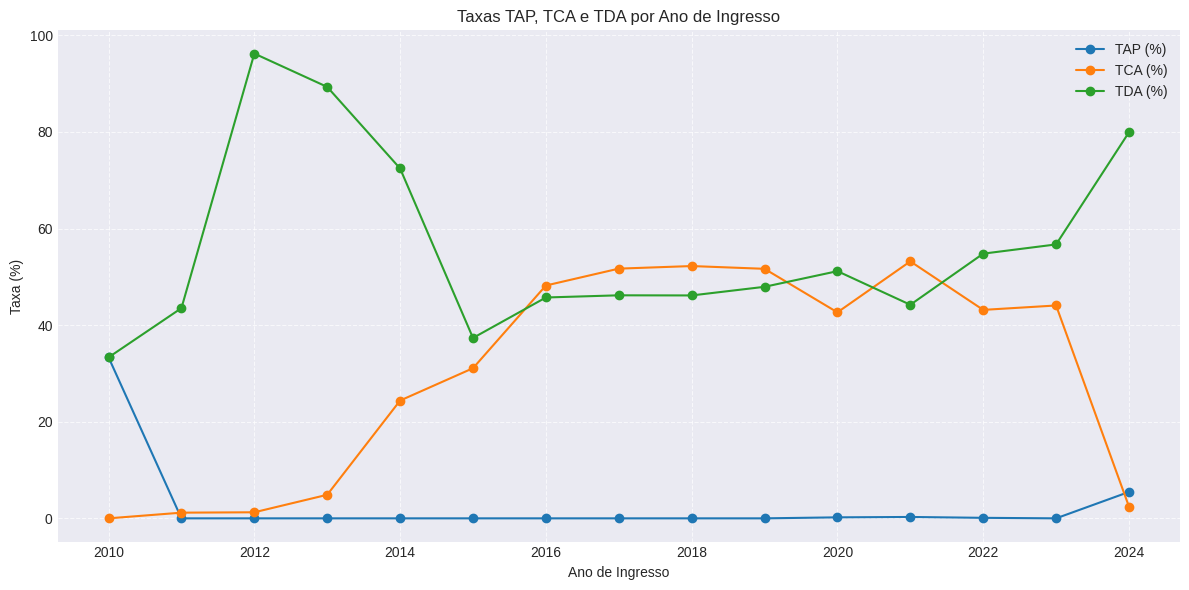

In [45]:
# Mesclar os 3 dataframes em um só para plotar
df_consolidado = df_tap_simplificada.merge(
    df_tca_simplificada, on='Ano_ingresso', how='outer'
).merge(
    df_tda_simplificada, on='Ano_ingresso', how='outer'
)

# Ordenar pelo ano de ingresso
df_consolidado = df_consolidado.sort_values('Ano_ingresso')

# Plotar
plt.figure(figsize=(12, 6))
plt.plot(df_consolidado['Ano_ingresso'], df_consolidado['TAP_simplificada'], marker='o', label='TAP (%)')
plt.plot(df_consolidado['Ano_ingresso'], df_consolidado['TCA_simplificada'], marker='o', label='TCA (%)')
plt.plot(df_consolidado['Ano_ingresso'], df_consolidado['TDA_simplificada'], marker='o', label='TDA (%)')

plt.title('Taxas TAP, TCA e TDA por Ano de Ingresso')
plt.xlabel('Ano de Ingresso')
plt.ylabel('Taxa (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

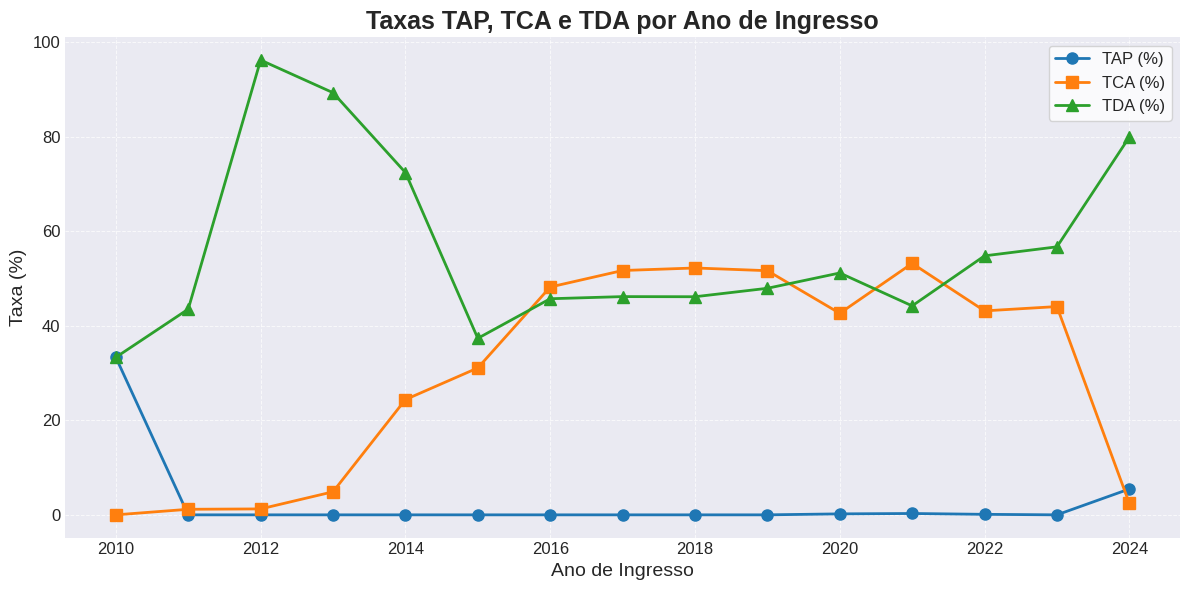

In [46]:
# Mesclar os 3 dataframes em um só para plotar
df_consolidado = df_tap_simplificada.merge(
    df_tca_simplificada, on='Ano_ingresso', how='outer'
).merge(
    df_tda_simplificada, on='Ano_ingresso', how='outer'
)

# Ordenar pelo ano de ingresso
df_consolidado = df_consolidado.sort_values('Ano_ingresso')

# Estilo mais bonito
plt.style.use('seaborn-v0_8-darkgrid')

# Criar figura
plt.figure(figsize=(12, 6))

# Plot TAP
plt.plot(df_consolidado['Ano_ingresso'], df_consolidado['TAP_simplificada'],
         marker='o', markersize=8, linewidth=2, label='TAP (%)')

# Plot TCA
plt.plot(df_consolidado['Ano_ingresso'], df_consolidado['TCA_simplificada'],
         marker='s', markersize=8, linewidth=2, label='TCA (%)')

# Plot TDA
plt.plot(df_consolidado['Ano_ingresso'], df_consolidado['TDA_simplificada'],
         marker='^', markersize=8, linewidth=2, label='TDA (%)')

# Títulos e legendas
plt.title('Taxas TAP, TCA e TDA por Ano de Ingresso', fontsize=18, fontweight='bold')
plt.xlabel('Ano de Ingresso', fontsize=14)
plt.ylabel('Taxa (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Legenda com fundo branco
plt.legend(fontsize=12, loc='best', frameon=True, facecolor='white')

# Layout ajustado
plt.tight_layout()

# Exibir
plt.show()

Importante descobrir em que ano o aluno entrou e saiu, saber se o motivo da saída foi desistência ou fatores externos como troca de curso, trancamento de matrícula(isso temos de informação do DataSet), talvez saber em que período ocorreu a desistência seja importante(também temos), pois pode ser advindo do curso, por exemplo ter um primeiro semestre muito complicado para novatos.

Tentar descobrir porquê em 2024 teve esse aumento de 23% na taxa de desistência(talvez por conta da greve), tentando descobrir como e porquê tanta gente desistiu a mais que o normal.

Minha outra pesquisa por DataSet deu como a situação financeira sendo o principal, problemas por dívidas, falta de bolsas estudantis, provavel dificuldade financeira dos pais, então acredito que essa é uma pesquisa importante a ser feita, tanto que ela é bem explorada no ENEM, com perguntas como "Quantos banheiros você tem em casa?" etc.


